# Импорты

In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
import itertools
from sklearn.neural_network import MLPRegressor

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from pathlib import Path


IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install catboost

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

In [2]:
DATA_DIR = Path("data")
HOUSING_PATH = DATA_DIR / "housing.csv"
HOTEL_PATH = DATA_DIR / "Hotel Reservations.csv"


def model_summary(y_true, y_pred):
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    print(f"Средняя абсолютная ошибка: {mae:.3f}")
    print(f"Средняя абсолютная процентная ошибка: {mape:.3f}")

    plt.scatter(x=y_pred, y=y_true, label="Реальное предсказание")
    plt.plot(y_true, y_true, linestyle="--", color="orange", label="Идеальное предсказание")
    plt.xlabel("Предсказание")
    plt.xlabel("Таргет")
    plt.legend()
    plt.show()

# Разбор метрик бинарной классификации

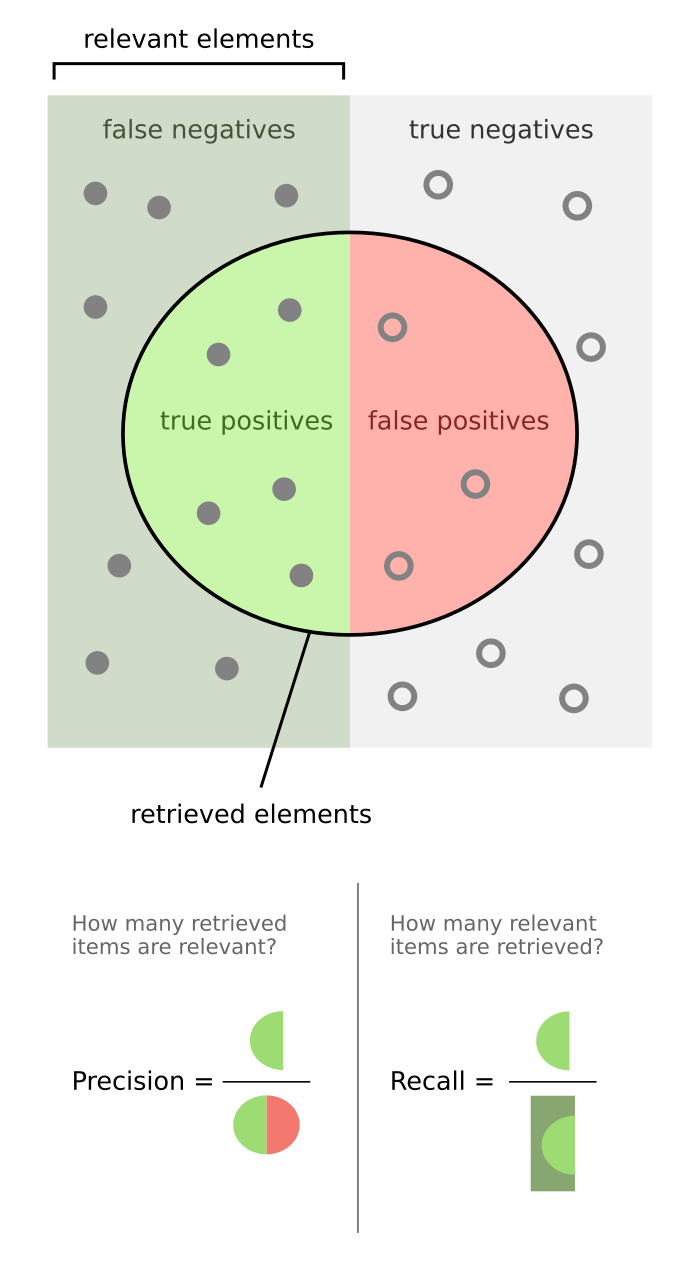

$$\text{f1 score} = \frac{2 * precision * recall}{precision + recall}$$

f1 score является гармоническим средним

**Задача**

Попробуем ответить на вопросы
- Как на precision и recall влияет появление большого количества ложноположительных (false positive) срабатываний?
- А как влияет появление большого количества ложноотрицательных (false negative) срабатываний?
- Какие могут быть примеры задач, где есть важность типа ошибки классификации? Какую из метрик стоит там использовать?
- В чем смысл использования гармонического среднего?

# Проблемы в ML

## Переобучение

[Ссылка на файл датасета](https://drive.google.com/file/d/1SCYD2qDlrybLVfiFObKJS9bwUPJLpcIW/view?usp=sharing)

[Информация о датасете](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

In [3]:
df = pd.read_csv(HOUSING_PATH)
target = "median_house_value"
X = df.select_dtypes(exclude=object).drop(columns=target)
y = df[target]

Качество на той же выборке, на которой обучали
Средняя абсолютная ошибка: 11594.144
Средняя абсолютная процентная ошибка: 0.064


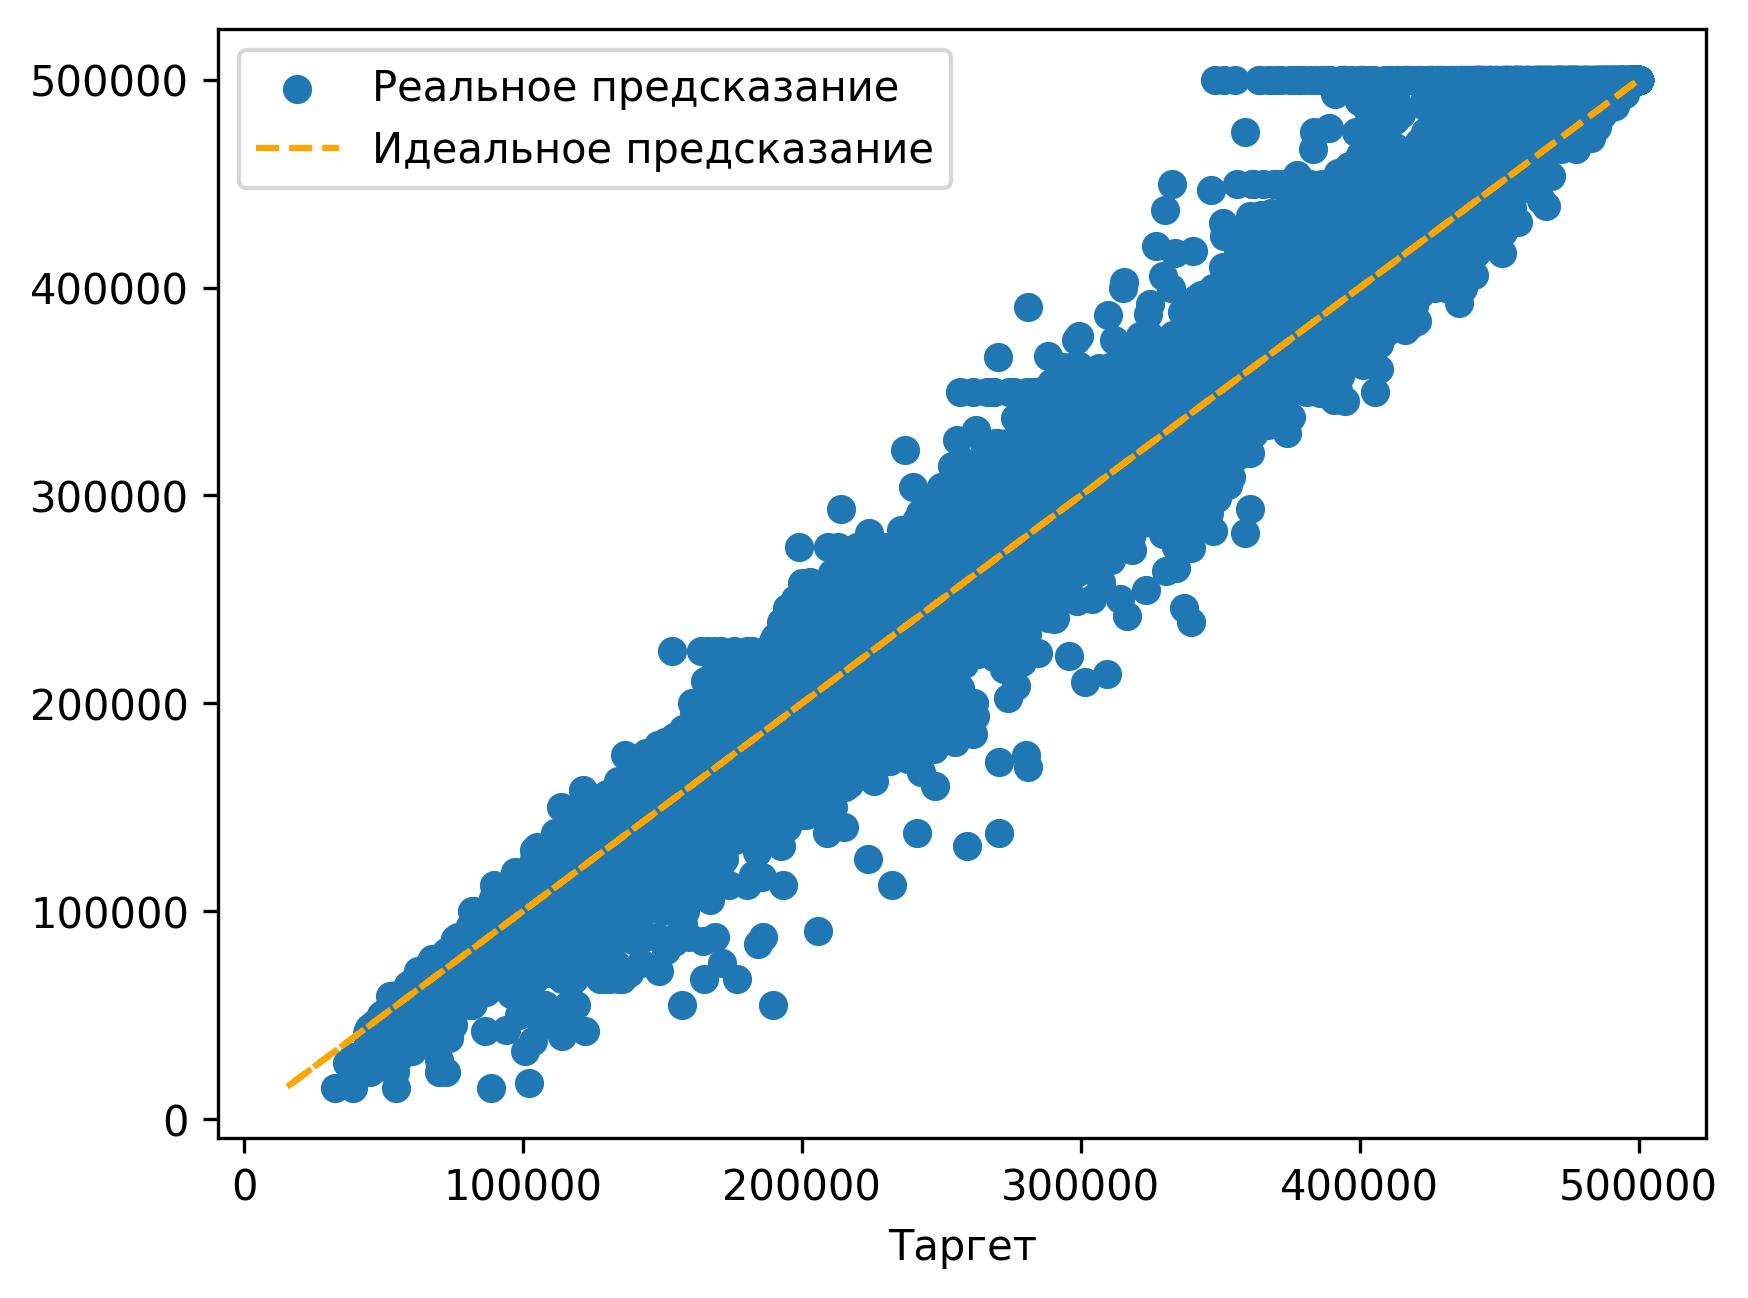

In [4]:
model = RandomForestRegressor(n_estimators=100, n_jobs=11)
model.fit(X, y)
pred = model.predict(X)

print("Качество на той же выборке, на которой обучали")
model_summary(y_true=y, y_pred=pred)

Качество на отдельной (тестовой) выборке
Средняя абсолютная ошибка: 32181.556
Средняя абсолютная процентная ошибка: 0.179


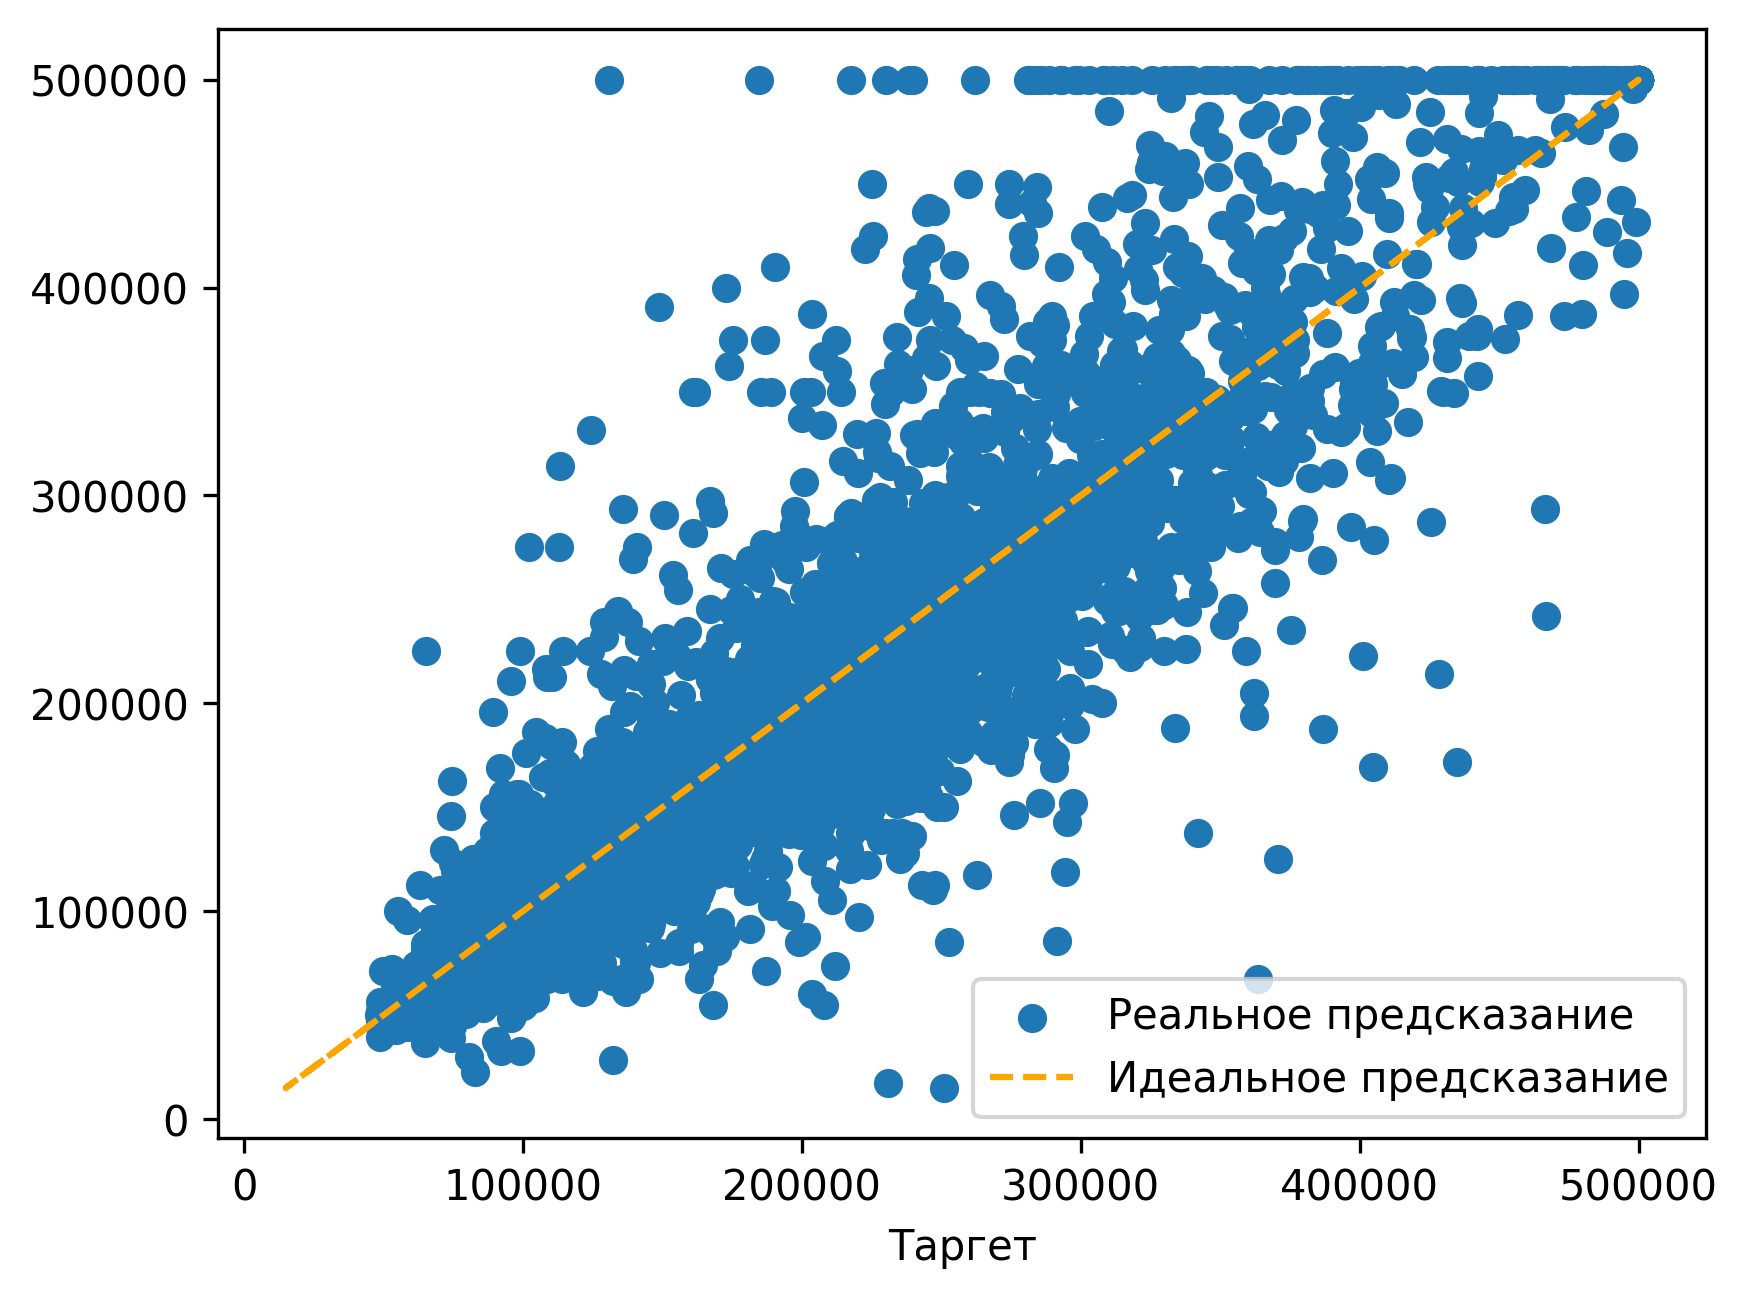

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, n_jobs=11)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Качество на отдельной (тестовой) выборке")
model_summary(y_true=y_test, y_pred=pred)

Способ борьбы с обучением - регуляризация (наложение ограничений на сложность модели). За сложности модели отвечают ее гиперпараметры
Перебор параметров - можно пытаться найти такие гиперпараметры модели, при которой качество будет лучше

Примеры подходов:
- GridSearch
- RandomSearch
- optuna

Однако для большей "честности" стоит перебирать их на выборке, отличной от теста

Пример ручной реализации GridSearch:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

params = {
    "min_samples_split": [2, 5, 10],
    "n_estimators": [200, 400, 600],
}

best_params = None
best_mape = float("inf")
for min_samples_split, n_estimators in tqdm(
    list(itertools.product(params["min_samples_split"], params["n_estimators"]))
):
    model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, n_jobs=11)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    cur_mape = mean_absolute_percentage_error(y_true=y_val, y_pred=pred)
    if cur_mape < best_mape:
        best_mape = cur_mape
        best_params = {"min_samples_split": min_samples_split, "n_estimators": n_estimators}

best_mape, best_params

100%|██████████| 9/9 [00:19<00:00,  2.16s/it]


(0.17859031688923205, {'min_samples_split': 2, 'n_estimators': 400})

Средняя абсолютная ошибка: 31991.078
Средняя абсолютная процентная ошибка: 0.179


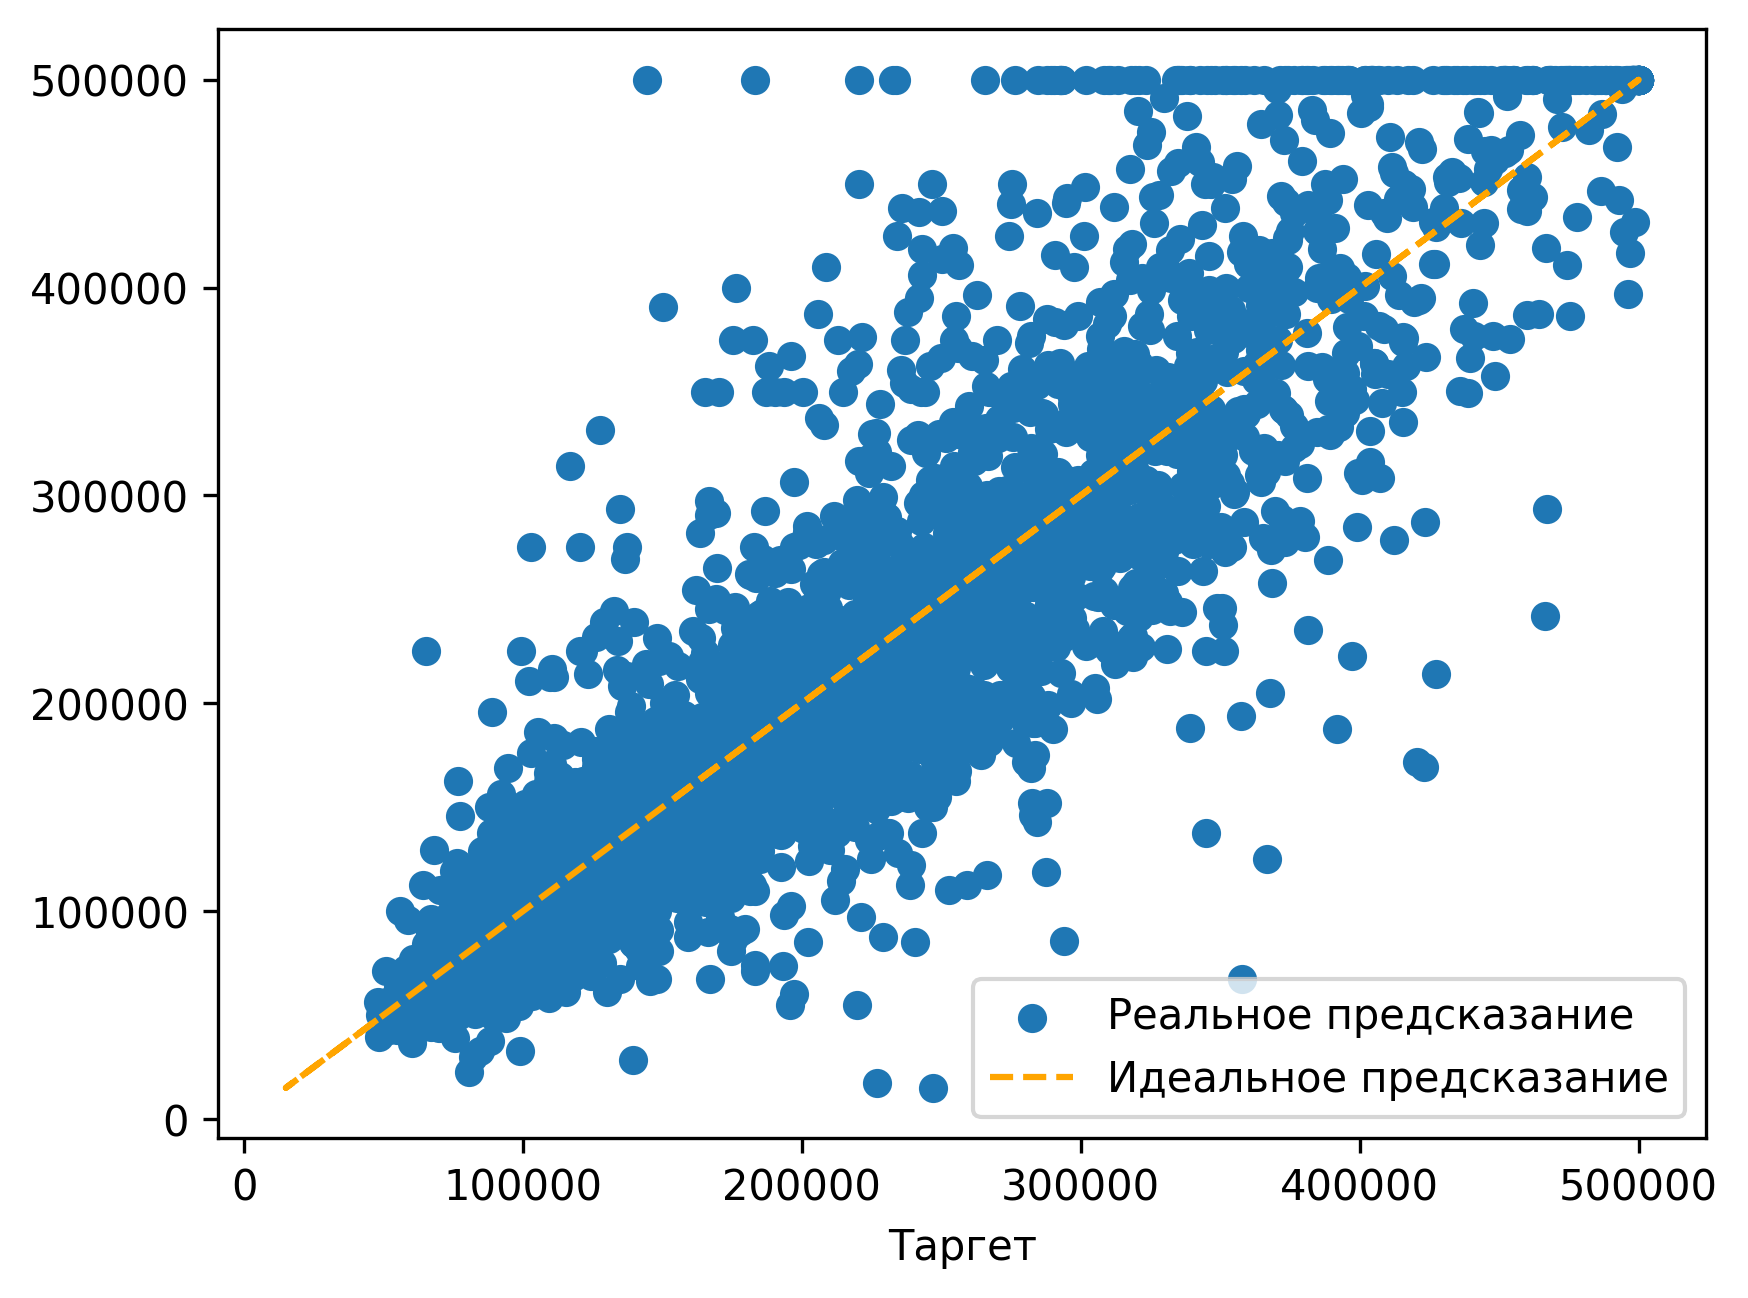

In [7]:
model = RandomForestRegressor(**best_params, n_jobs=11)
model.fit(pd.concat((X_train, X_val)), pd.concat((y_train, y_val)))
pred = model.predict(X_test)
model_summary(y_true=y_test, y_pred=pred)

Однако есть встроенные GridSearch в sklearn, он делает кроссвалидацию

Средняя абсолютная ошибка: 32766.579
Средняя абсолютная процентная ошибка: 0.182


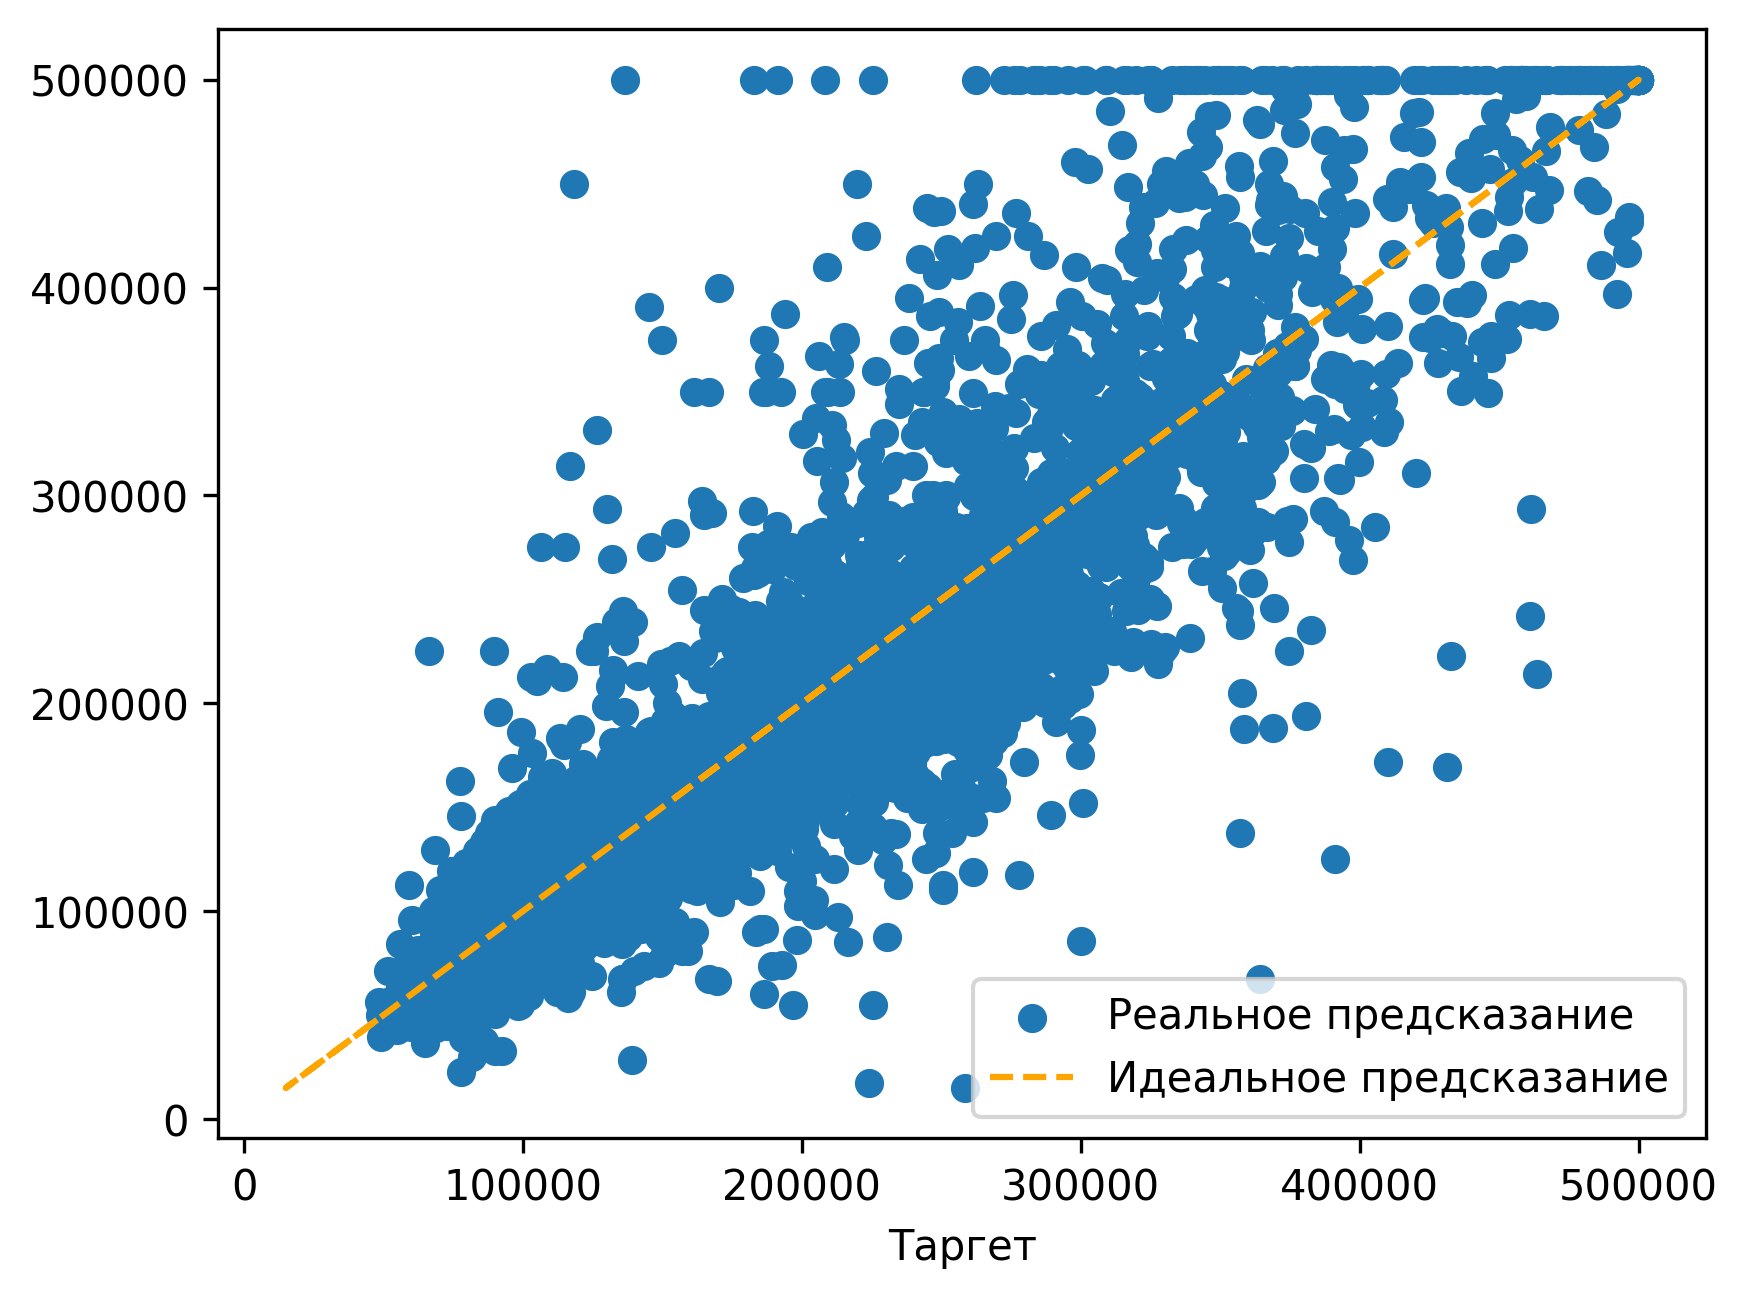

In [8]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=11)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model_summary(y_true=y_test, y_pred=pred)

## Дизбаланс классов

Для борьбы с несбалансированностью классов в задаче классификации применяют следующие методы:
- Модификация ошибки для увеличения важности редких классов
- Андерсэмплинг: уменьшение тренировочного датасета для балансировки
- Оверсэмплинг: добавление в тренировочный датасет дополнительных примеров с редкими классами - при помощи дублирования или генерации синтетических данных (популярный пример - SMOTE)

- [датасет](https://drive.google.com/file/d/1SDBuPOtEYY5vqtbCrkpsgoGjucNVYFWr/view?usp=sharing)
- [информация о датасете](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)

In [9]:
df = pd.read_csv(HOTEL_PATH)
target = "booking_status"
pos_class = "Canceled"
# Make unbalanced
df_pos_class_sample = df[df[target] == pos_class].sample(frac=0.2, random_state=1)
df = pd.concat([df_pos_class_sample, df[df[target] != pos_class]])

Обычный запуск кэтбуста:

In [10]:
y = df[target]
X = df.drop(columns=target)
cat_cols = list(X.select_dtypes(object).columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(cat_features=cat_cols, allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
metric = f1_score(y_true=y_test, y_pred=pred, pos_label=pos_class)
print(f"f1: {metric:.3f}")

f1: 0.607


У катбуста есть встроенный параметр, меняющий ошибку для баланса

In [11]:
model = CatBoostClassifier(
    cat_features=cat_cols, allow_writing_files=False, auto_class_weights="SqrtBalanced", verbose=False
)
model.fit(X_train, y_train)
pred = model.predict(X_test)
metric = f1_score(y_true=y_test, y_pred=pred, pos_label=pos_class)
print(f"f1: {metric:.3f}")

f1: 0.658


# MLP

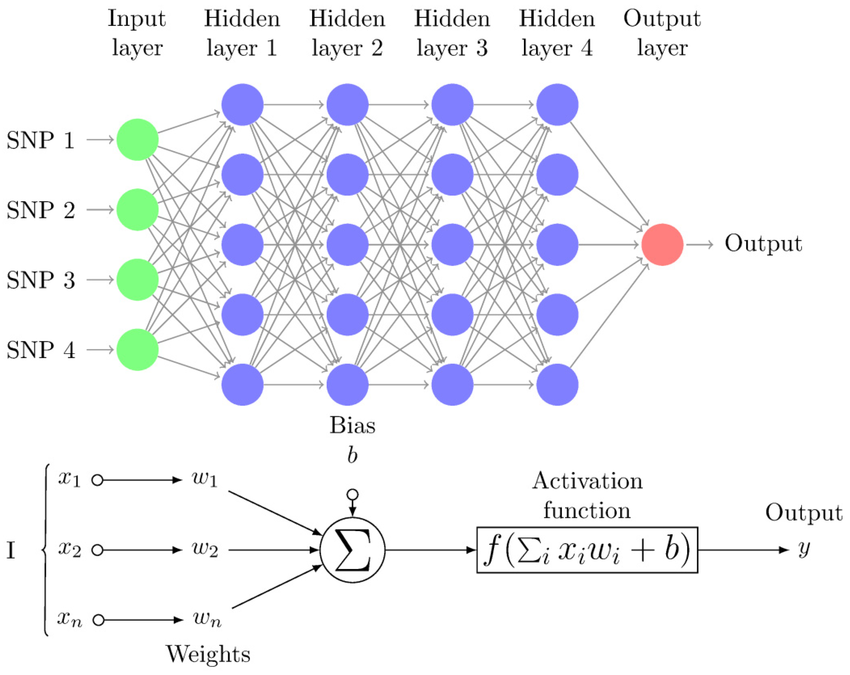

In [13]:
pd.read_csv(HOTEL_PATH)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


Средняя абсолютная ошибка: 78962.450
Средняя абсолютная процентная ошибка: 0.576


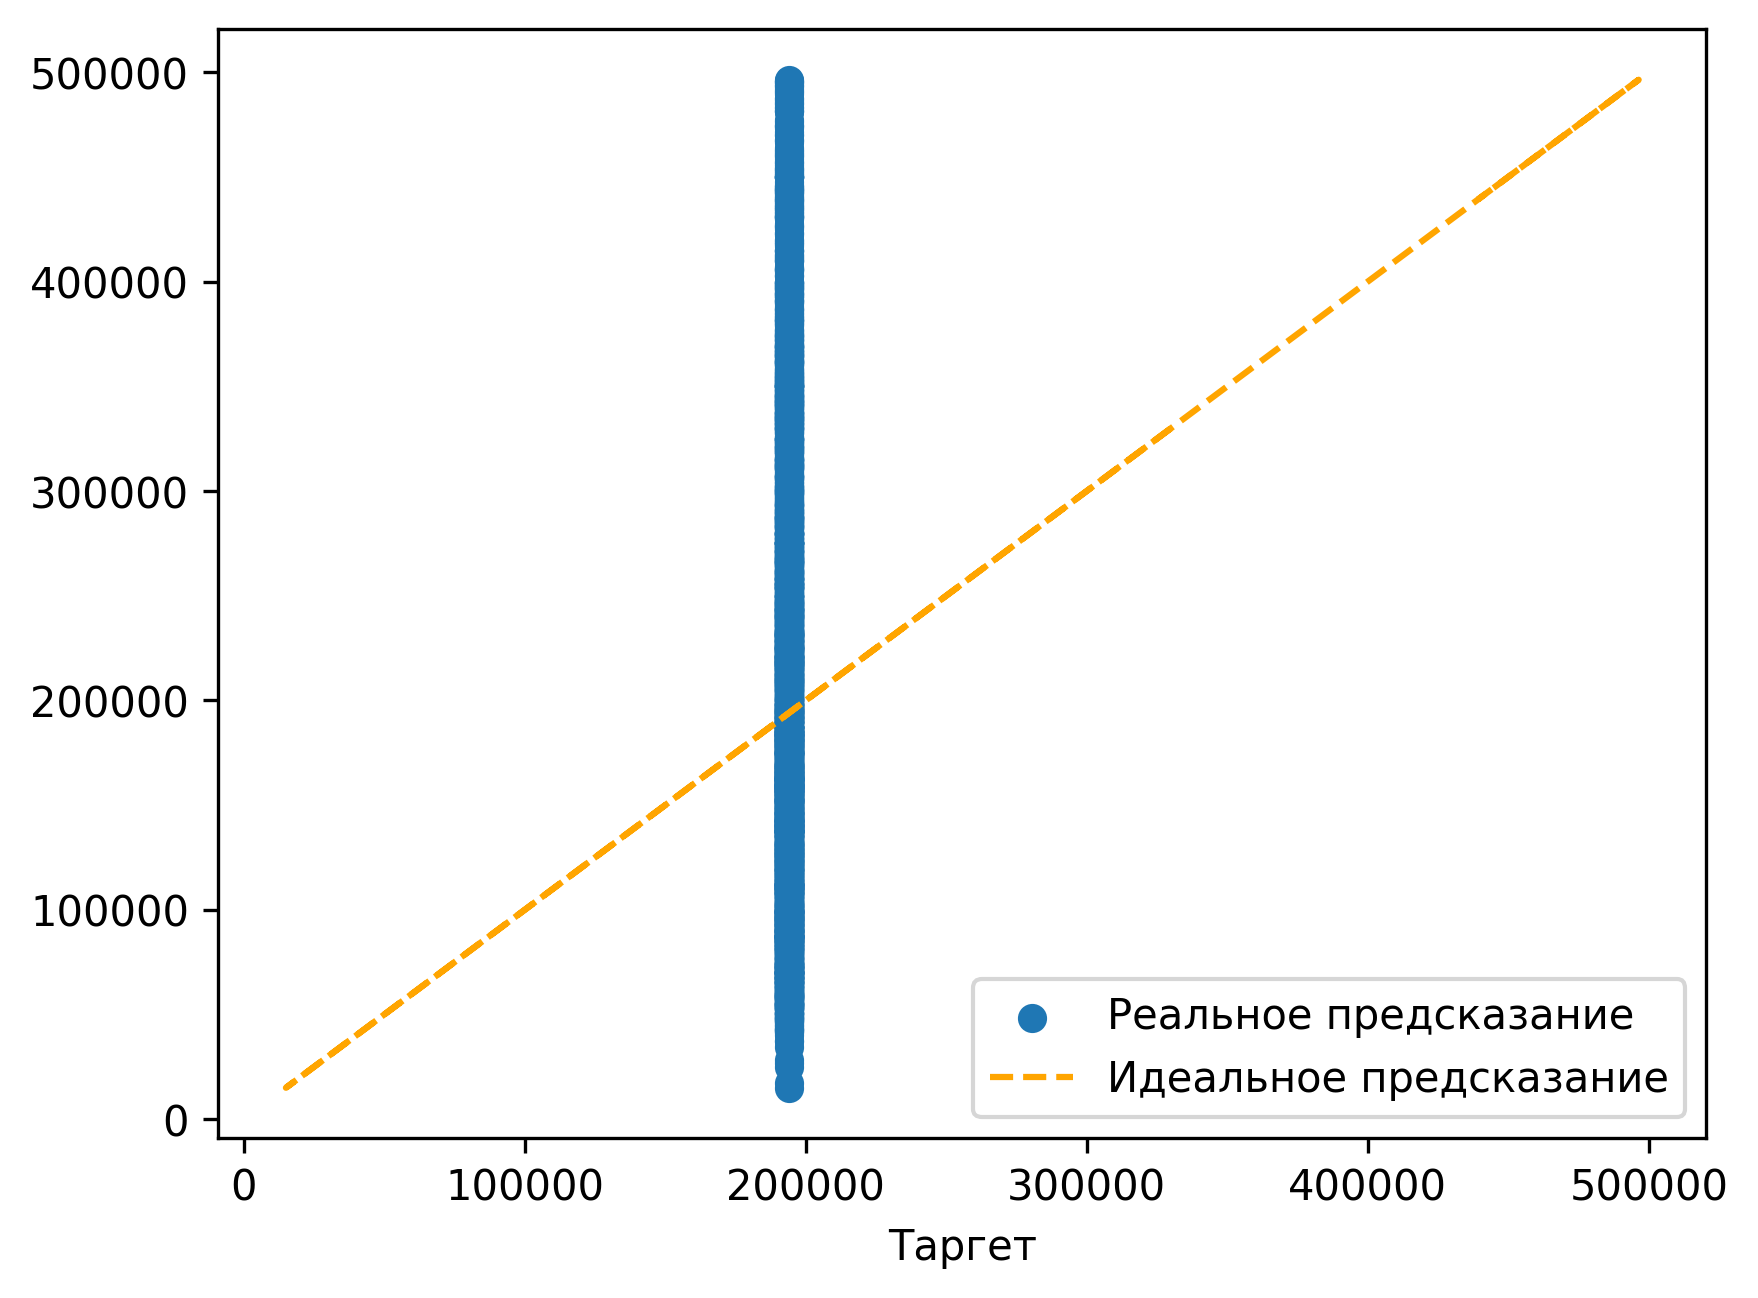

In [23]:
def load_hotel_data():
    df = pd.read_csv(HOUSING_PATH)
    target = "median_house_value"
    df = df[df[target] < 500_000]
    X = df.select_dtypes(exclude=object).drop(columns=target)
    y = df[target]
    return X, y


X, y = load_hotel_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=[10, 10],
        activation="relu",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=1,
        solver="sgd",
    ),
)
model.fit(X_train, y_train)

pred = model.predict(X_test)
model_summary(y_true=y_test, y_pred=pred)

Модели с оптимизацией градиентным спуском очень чувствительны к большим значениям в признаках и таргете

Средняя абсолютная ошибка: 36127.401
Средняя абсолютная процентная ошибка: 0.222


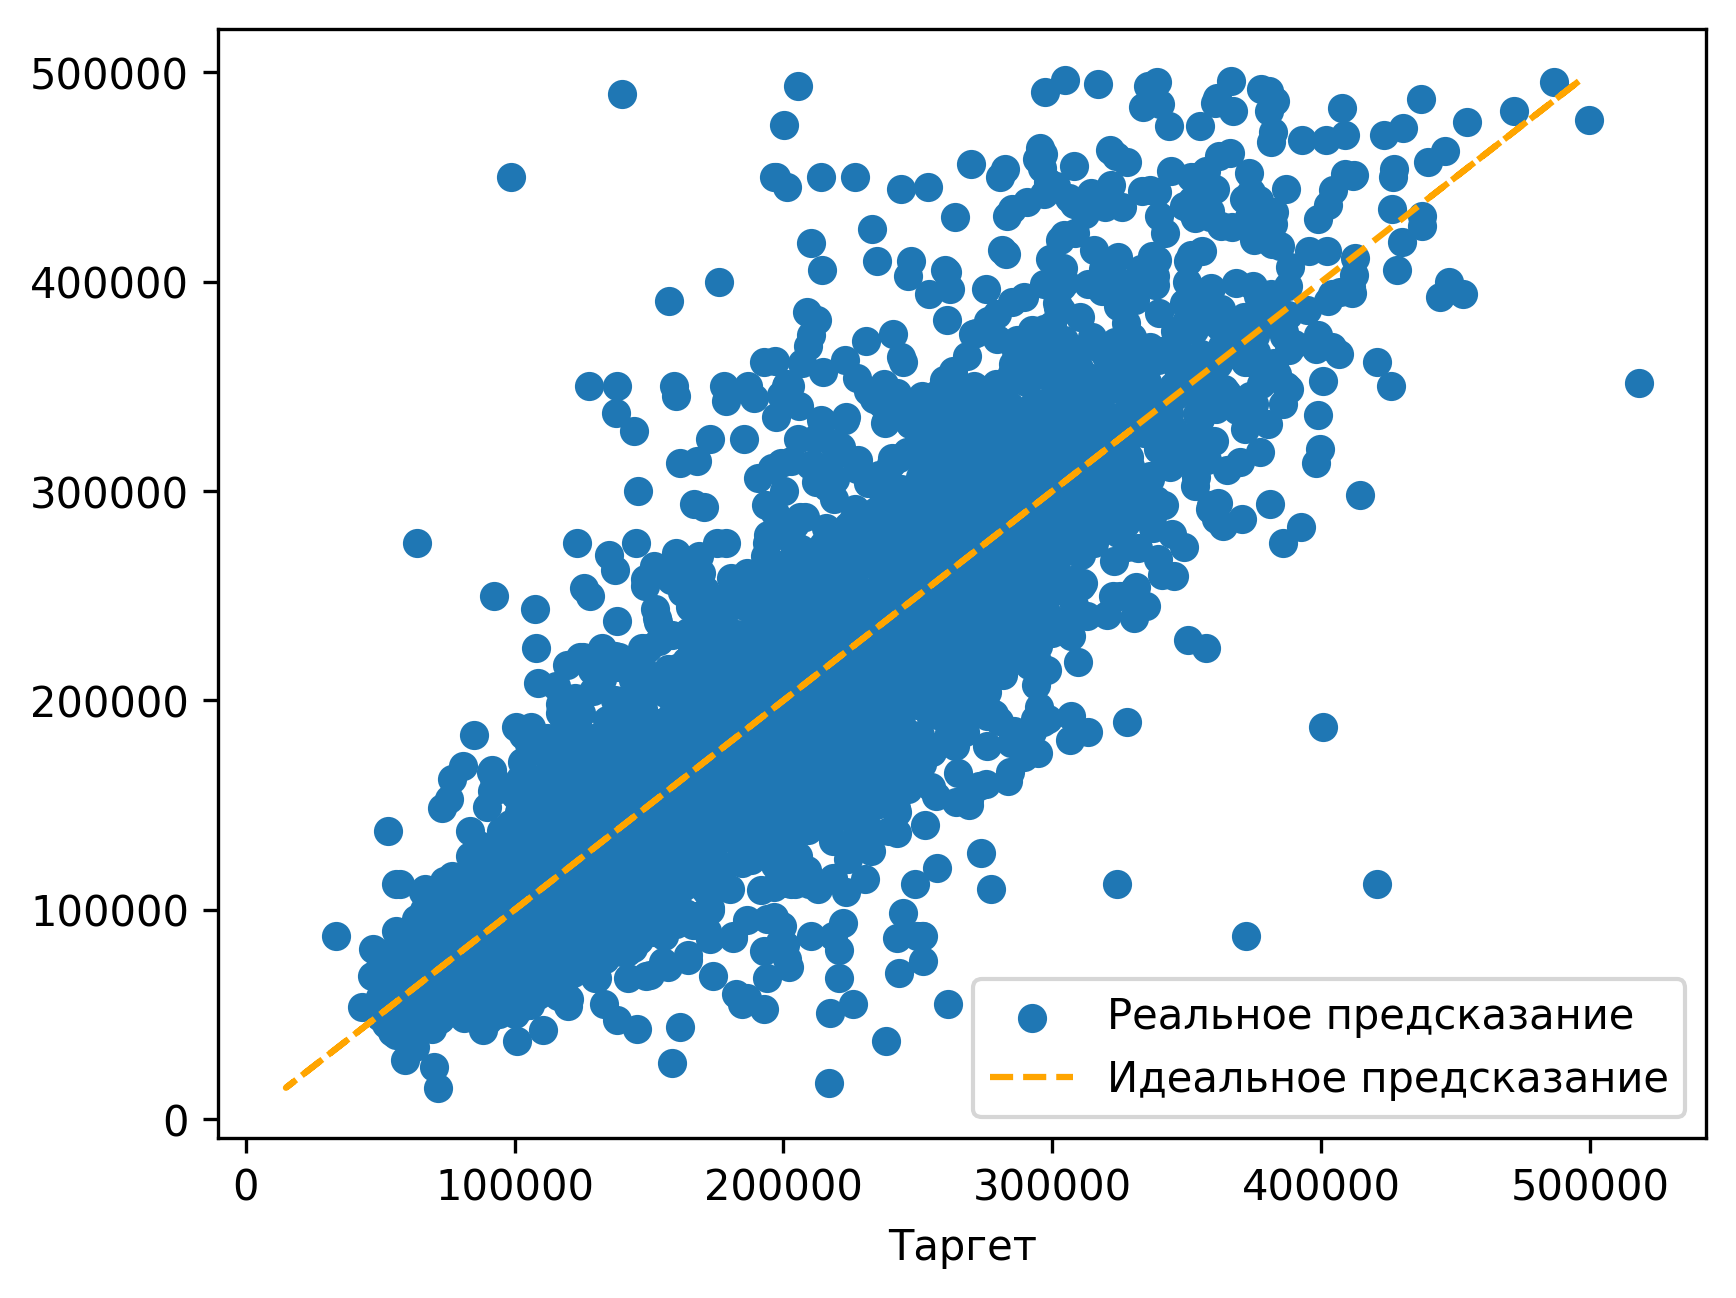

In [24]:
X, y = load_hotel_data()
y_mean, y_std = y.mean(), y.std()
y = (y - y_mean) / y_std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=[10, 10],
        activation="relu",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=1,
        solver="sgd",
    ),
)
model.fit(X_train, y_train)

pred = model.predict(X_test)
# Не делайте так
pred = pred * y_std + y_mean
y_test = y_test * y_std + y_mean
model_summary(y_true=y_test, y_pred=pred)

Самые важные гиперпараметры в НН:
- Количество эпох (max_iter)
- Размер learning_rate
- Сколько слоев/их размерности
- Какие активации используются (в sklearn адекватная только relu)

Задача: попробуйте разные значения гиперпараметров, как они влияют на качество модели?